#**Word-level Language Modelling**


## Table of Contents
1. 자연어 처리(NLP)를 위한 전처리 과정
2. 단어 임베딩(Word Embedding)
3. 모델 구현
4. Training and Evaluation
5. Reference




+ IMDB 리뷰 감성 분류하기
    - IMDB 리뷰 데이터는 영화에 대한 리뷰 텍스트를 입력으로 받아 긍정인 경우 1을 부정인 경우 0으로 나타내도록 레이블된 데이터 이다.
    - 따라서 RNN의 구조는 다음과 같은 Many to one의 형태가 된다.

    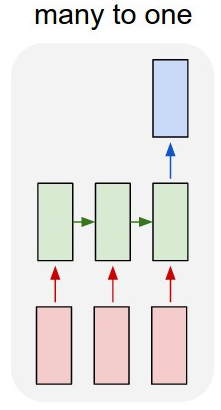    

In [ ]:
# Parameter setting
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random

from tqdm import tqdm
import time


#랜덤 시드로 고정
seed1 = 5
random.seed(seed1)
torch.manual_seed(seed1)

batch_size = 64
lr = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1-1 자연어 처리(NLP)를 위한 전처리 과정**

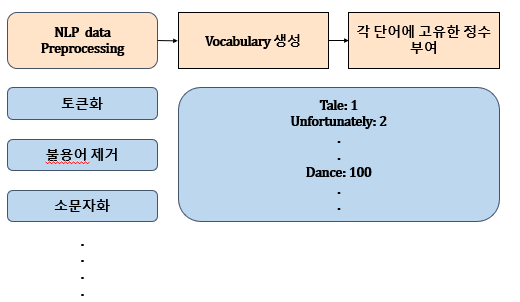

- NLP data preprocessing
    
    - 소문자화 : 영어 알파벳을 모두 소문자화
    - 구두점 제거 : 특수문자 및 기호의 제거
    - 토큰화(Tokenization) : 데이터를 단어별로 구분한다.
    - 불용어(stop word) 제거 : 큰 의미가 없는 단어(전치사, be 동사 등)들을 제거

In [ ]:
# nltk는 자연어 처리를 위한 파이썬 패키지
!pip install nltk

import nltk

text = "It is a TRUTH universally acknowledged, that a SINGLE man in possession of a good fortune, MUST be in want of a wife."

## 1) Lowercase (소문자화)

In [ ]:

text = text.lower()
print(text)

## 2) Removing Punctuation (구두점 제거)

In [ ]:
import string
print(string.punctuation)

In [ ]:
text_remove_p = "".join([char for char in text if char not in string.punctuation])
print(text_remove_p)

## 3) Tokenization (토큰화)

In [ ]:
from nltk import word_tokenize

nltk.download('punkt') # tokenization을 위한 데이터 다운로드
words = word_tokenize(text_remove_p)
print(words)

## 4) Stopword Filtering(불용어 처리)
- 불용어란, 자주 등장하지만 분석을 하는데 있어서 큰 도움이 되지 않는 단어들로 의미 분석을 할때는 필요에 따라 제거해 준다.

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords') # 불용어 처리를 위한 데이터 다운로드

stop_words = stopwords.words('english')
print(stop_words)

In [ ]:
filtered_words = [word for word in words if word not in stop_words]
print(filtered_words)

## **1-2 Torchtext를 이용한 자연어 처리(NLP)를 위한 전처리 과정**
- PyTorch에서는 텍스트에 대한 여러 추상화 기능을 제공하는 자연어 처리 library인 Torchtext를 제공한다. 


### 1) 데이터 전처리

In [ ]:
from torchtext import data # torchtext.data 임포트

# 필드 정의 - torchtext.data에는 필드(Field)라는 도구를 제공하여 어떤 전처리를 할 것인지를 정의

TEXT = data.Field(sequential=True, # 시퀀스 데이터 여부
                  use_vocab=True, # 단어 집합을 만들 것인지 여부
                  tokenize=str.split, # 어떤 토큰화 함수를 사용할 것인지 지정
                  lower=True, # 영어 데이터를 전부 소문자화한다
                  batch_first=True) # 미니 배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지 여부
                  #fix_length=20) # 최대 허용 길이. 이 길이에 맞춰서 패딩 작업(Padding)이 진행됨

LABEL = data.Field(sequential=False,
                   batch_first=False,
                   is_target=True) # 레이블 데이터 여부


### 2) 데이터 로딩


In [ ]:
trainset, testset = datasets.IMDB.splits(TEXT, LABEL) # 훈련 테스트 데이터가 8:2로 나뉘어짐. # trainset, testset = datasets.IMDB.splits(TEXT, LABEL) # 훈련 테스트 데이터가 8:2로 나뉘어짐.
# 두개의 필드 객체(TEXT, LABEL)에 의해 데이터 전처리가 이루어짐.

In [ ]:
print(vars(trainset[5]))

### 3) 단어 집합 만들기
- trainset에서 추출된 중복을 제거한 총 단어들의 집합을 의미한다.

In [ ]:
TEXT.build_vocab(trainset, min_freq=5) # 단어 집합 생성 # min_freq : trainset에서 최소 5번 이상 등장한 단어만을 단어 집합에 추가 # 다섯번 미만으로 등장하는 단어들은 Unknown이라는 의미에서 <unk>라는 토큰으로 대체됨.
LABEL.build_vocab(trainset)

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 2
print('단어 집합의 크기 : {}'.format(vocab_size))
print('클래스의 개수 : {}'.format(n_classes))

In [ ]:
TEXT.vocab.stoi # 단어와 그 단어의 정수 인덱스를 확인
#  토치텍스트는 <unk>의 번호는 0번, <pad>의 번호는 1번을 할당
# <unk>는 단어 집합에 없는 단어를 표현할 때 사용되며
# <pad>는 길이를 맞추는 패딩 작업을 할 때 사용됩니다.

### 4) 데이터 로더 만들기
- 토치텍스트는 모든 텍스트를 배치 처리하는 것을 지원하고, 위에서 만든 단어 집합을 이용하여, 단어를 인덱스 번호로 대체하는 BucketIterator를 제공한다.

In [ ]:
train_iter, test_iter = data.BucketIterator.splits(
        (trainset, testset), batch_size=batch_size,
        shuffle=True, repeat=False)
batch = next(iter(train_iter)) # 첫번째 미니배치



In [ ]:
print(batch.text)

- 문장의 길이(sequence length)는 sample마다 다르지만 한 배치에서 shape은 통일되어야 하기 때문에 한 배치 내의 가장 긴 길이를 가지는 샘플의 길이 만큼 1로 padding 되어 있는 것을 확인 가능.

In [ ]:
batch = next(iter(train_iter)) # 두번째 미니배치
print(batch.text.shape)



- mini-batch의 크기는 (batch_size, sequence length)가 된다.

- 현재 fix_length를 정해주지 않았으므로 미니 배치 간 샘플들의 길이는 전부 다르게 된다. 

- 위의 코드로 인하여 미니배치가 꺼내지므로 다시 담기위해 재로드 해준다.

In [ ]:
trainset, valset = trainset.split(split_ratio=0.8)

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=batch_size,
        shuffle=True, repeat=False)

## **2. 단어 임베딩(Word Embedding)**

+ 단어 집합을 정수 인코딩 시켜준 뒤에 입력 정수에 대해 벡터로 맵핑하는 작업이다. 이는 네트워크에 인풋으로 넣기위해 단어를 벡터로 표현해야 하기 때문이며 다음과 같은 방법이 있다.
    - 1) One-hot vector : 단어 하나를 하나의 Discrete Variable로 취급. 각 단어의 구분은 가능하지만 유사도를 측정할 수는 없다. 단어 갯수 만큼 벡터 차원이 필요하게 되어 1만개의 단어를 바꾸게 되었을 때 1만 차원의 벡터가 필요하므로 차원의 저주가 발생. 
    
    예를 들어,
        
        - 파이토치 ->    [1,0,0,0]
        - 텐서 플로우 -> [0,1,0,0]
        - 구글   ->    [0,0,1,0]
        - 페북    ->   [0,0,0,1]

    - 2) Dense vector : 비교적 낮은 차원의 벡터에 단어의 의미를 분산하여 dense한 vector로 표현. 단어를 dense vector의 형태로 표현하는 방법을 단어 임베딩(Word Embedding)이라고 하며 dense vector를 단어 임베딩 과정을 통해 나온 결과라고 하여 임베딩 벡터(Embedding vector)라고 한다.

    예를 들어,

        - 파이토치   ->  [0.2, 0.4]
        - 텐서 플로우 -> [0.1, 0,7]
        - 구글   ->    [0,5, 0.5]
        - 페북   ->    [0.9, 0.2]

    - PyTorch에서 임베딩 벡터를 사용하는 방법에는 다음과 같은 두가지가 있다.
        - 1) 임베딩 층을 만들어 훈련 데이터로부터 임베딩 벡터를 학습하는 방법이며 해당 Task에 특화된 임베딩 벡터를 만들어 낼 수 있다 : PyTorch의 nn.Embedding()으로 구현 가능.
        - 2) 미리 사전에 훈련된 임베딩 벡터(Pretrained word embedding)들을 가져와 사용하는 방법. 문제에 특화된 것은 아니지만 보다 일반적이고 많은 훈련 데이터로 이미 Word2Vec이나 Glove 등의 방법으로 학습되어진 임베딩 벡터를 사용.

- **PyTorch에서의 nn.Embedding()**
    - 아래 그림을 살펴 보면 great이 정수 인코딩 된 후 테이블로 부터 해당 인덱스에 위치한 임베딩 벡터를 꺼내오는 모습을 보여준다. Embedding vector의 차원이 4로 설정되어 임베딩 되어 있는 것을 확인해 볼 수 있으며, 테이블의 101 번째에 위치한 행을 단어 great의 임베딩 벡터로 사용한다. 이 벡터가 모델의 입력이 되며 Learnable한 parameter들로써 ( shape은 [단어 집합 사이즈, embedding 차원]이 되며 초기화는 Gaussian distribution으로 된다.) 학습의 역전파 과정 중에 학습 되어진다.

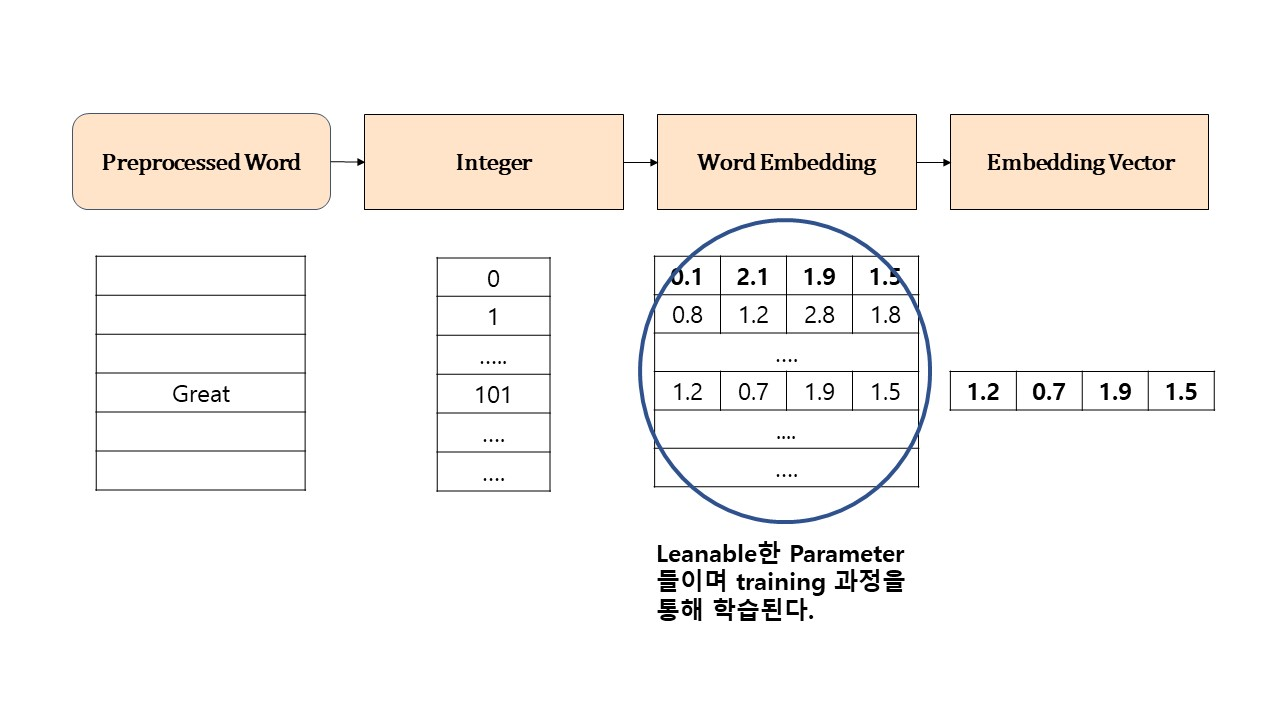

## **3. 모델 구현하기**

In [ ]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)   # nn.Embedding() 정의하기     # 단어 집합 크기와 embedding 차원을 입력으로 넣는다.
        self.dropout = nn.Dropout(dropout_p)
        self.gru =  nn.GRU(embed_dim, self.hidden_dim,
            num_layers=self.n_layers,
            batch_first=True
        )    # nn.GRU() 정의하기
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (batch size, sequence length, hidden state의 크기)
        h_t = x[:,-1,:] # 즉, 마지막 time-step의 hidden state만 가져온다. (batch size, hidden state의 크기)의 텐서로 크기가 변경됨.
        self.dropout(h_t)
        logit = self.out(h_t)  # (batch size, hidden state의 크기) -> (batch size, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [ ]:
#모델 정의 및 optimizer 정의
model = GRU(1, 256, vocab_size, 128, n_classes, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## **4. Training and Evaluation**

In [ ]:
def train(model, optimizer, train_iter, DEVICE):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

def evaluate(model, val_iter, DEVICE):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [ ]:
#Model training
best_val_loss = None
for e in tqdm(range(1, epochs+1)):
    train(model, optimizer, train_iter, device)
    val_loss, val_accuracy = evaluate(model, val_iter, device)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # Validation 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

In [ ]:
#Model evaluation
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter, device)
print('test loss: %5.2f | text accuracy: %5.2f' % (test_loss, test_acc))

### **테스트 샘플로 결과 확인하기**

In [ ]:
#테스트 샘플로 예측해보기

import numpy as np

test_example = vars(testset[5])
print('The text of test example: ', test_example['text'])

In [ ]:
index_vector = []

for text in test_example['text']:
    index_vector.append(TEXT.vocab.stoi[text])

index_vector_numpy = np.array(index_vector)
index_vector_tensor = torch.from_numpy(index_vector_numpy)
index_vector_tensor = index_vector_tensor.view(1,index_vector_tensor.size(0))

prediction = model(index_vector_tensor.to(device)).max(1)[1].item()
prediction = 'pos' if prediction==1 else 'neg'

print('The prediction of our trained model on the test example:', prediction)
print('The true label of the test example:', test_example['label'])

### LSTM의 성능이 충분히 나오지 않을 때에는 다음과 같은 추가 옵션을 줄 수 있다.
1) Bidirectional option

2) Multi-Layer option

```python
lstm = nn.LSTM(3, 3, num_layers=2, batch_first=True, bidirectional=True)

```

**1) Bidirectional LSTM**
- 기존의 LSTM은 hidden state의 진행 방향이 한방향이므로 foward pass가 진행됨에 따라 초기 step의 정보가 사라질 수 있다. 이러한 문제를 해결하기 위해 양뱡향(bidirectional) 옵션을 추가하여 LSTM의 성능을 높일 수 있다.

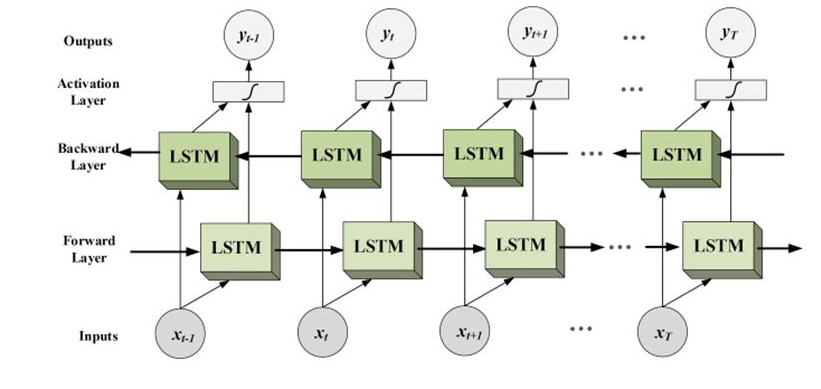

**2) Multi-layer LSTM**

- layer를 여러층으로 쌓아 모델의 크기를 증가시켜 성능을 높일 수 있다.

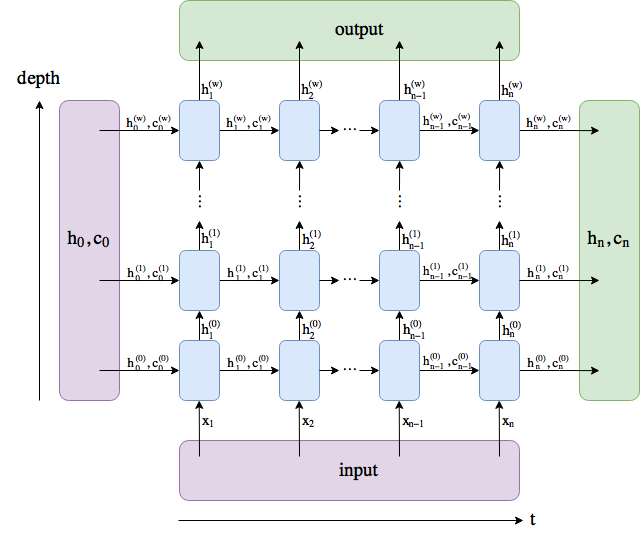

#**Reference**
https://towardsdatascience.com/nlp-preprocessing-with-nltk-3c04ee00edc0

https://wikidocs.net/64517

https://zzsza.github.io/data/2018/03/10/nlp-python/

https://i.stack.imgur.com/GmKNd.png

https://www.gousios.gr/courses/ml4se/2019/nn.html